In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,roc_curve,precision_recall_curve, average_precision_score,
                           mean_squared_error, mean_absolute_error, r2_score, accuracy_score)
from sklearn.calibration import calibration_curve
import statsmodels.api as sm
import shap


In [ ]:
df1 = pd.read_csv("psam_h34.csv")
df2 = pd.read_csv("psam_p34.csv")
merged_df = pd.merge(df1, df2, on='SERIALNO', how='inner')

In [ ]:
merged_df

,RT_x,SERIALNO,DIVISION_x,PUMA_x,REGION_x,STATE_x,ADJHSG,ADJINC_x,WGTP,NP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,H,2023GQ0000001,2,2501,1,34,1000000,1019518,0,1,...,68,66,67,69,69,67,68,71,65,67
1,H,2023GQ0000002,2,603,1,34,1000000,1019518,0,1,...,4,49,94,78,66,45,56,50,39,84
2,H,2023GQ0000021,2,2103,1,34,1000000,1019518,0,1,...,14,12,12,11,15,15,14,12,12,12
3,H,2023GQ0000058,2,307,1,34,1000000,1019518,0,1,...,3,2,2,4,4,2,4,2,4,2
4,H,2023GQ0000158,2,1201,1,34,1000000,1019518,0,1,...,2,2,20,20,16,24,29,3,16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94309,H,2023HU1459771,2,907,1,34,1000000,1019518,67,2,...,146,120,94,67,69,47,57,76,23,117
94310,H,2023HU1459772,2,904,1,34,1000000,1019518,64,1,...,63,18,21,66,63,64,60,75,97,18
94311,H,2023HU1459852,2,602,1,34,1000000,1019518,78,2,...,21,83,20,21,146,114,77,80,90,18
94312,H,2023HU1459852,2,602,1,34,1000000,1019518,78,2,...,32,84,25,19,149,118,90,111,84,19


In [ ]:
merged_df['JWTRNS'] = (merged_df['JWTRNS'] == 11).astype(int)
print(merged_df['JWTRNS'].value_counts())

JWTRNS
0    87181
1     7133
Name: count, dtype: int64


In [ ]:
all_cols = ['ACCESSINET', 'AGEP', 'BROADBND', 'COW', 'CPLT', 'DDRS', 'DEAR', 'DEYE', 'DIALUP', 'DOUT', 'DPHY', 'DREM', 'ESR', 'GCL', 'HFL', 'HHL', 'HHLDRAGEP', 'HHLDRHISP', 'HHT', 'HICOV', 'HINCP', 'HISP', 'HISPEED', 'HUGCL', 'HUPAC', 'HUPAOC', 'HUPARC', 'INDP', 'JWAP', 'JWDP', 'JWMNP', 'JWRIP', 'LANX', 'LAPTOP', 'MAR', 'MIG', 'PRIVCOV', 'PUBCOV', 'POWPUMA', 'R18', 'R60', 'R65', 'RAC1P', 'SATELLITE', 'SCHL', 'SMARTPHONE', 'TABLET', 'TEL', 'WIF', 'WKEXREL', 'WKHP', 'WKL', 'WKWN', 'WORKSTAT', 'WRK', 'JWTRNS']

# First filter for JWTRNS values of 0 and 1
filtered_df = merged_df[merged_df['JWTRNS'].isin([0, 1])]

# Calculate percentage of NaN values for each column
nan_percentages = (filtered_df[all_cols].isna().sum() / len(filtered_df)) * 100

# Identify columns with less than 20% NaN values
cols_to_keep = nan_percentages[nan_percentages < 20].index.tolist()

# Print columns being dropped due to high NaN percentage
dropped_cols = set(all_cols) - set(cols_to_keep)
print("\nColumns dropped due to >20% NaN values:")
for col in dropped_cols:
    print(f"{col}: {nan_percentages[col]:.2f}% NaN")

# Select columns with acceptable NaN levels
df_cleaned = filtered_df[cols_to_keep]

# Before dropping NaN rows, check class distribution
print("\nClass distribution before dropping NaN rows:")
print(df_cleaned['JWTRNS'].value_counts(normalize=True))

# Drop rows with NaN values
df_final = df_cleaned.dropna()

# Check final class distribution
print("\nClass distribution after dropping NaN rows:")
print(df_final['JWTRNS'].value_counts(normalize=True))

# Print shape at each step
print("\nShape at each step:")
print(f"Original: {merged_df.shape}")
print(f"After filtering JWTRNS: {filtered_df.shape}")
print(f"After dropping high-NaN columns: {df_cleaned.shape}")
print(f"Final after dropping NaN rows: {df_final.shape}")

# If you want to proceed with creating X and y:
X = df_final.drop('JWTRNS', axis=1)
y = df_final['JWTRNS']

# Optional: Print final number of records for each class
print("\nFinal number of records per class:")
print(y.value_counts())


Columns dropped due to >20% NaN values:
COW: 37.87% NaN
WKWN: 45.27% NaN
GCL: 32.15% NaN
WRK: 28.03% NaN
CPLT: 28.92% NaN
JWRIP: 64.80% NaN
INDP: 37.87% NaN
JWMNP: 58.33% NaN
JWAP: 58.33% NaN
JWDP: 58.33% NaN
WKHP: 45.27% NaN
POWPUMA: 50.76% NaN

Class distribution before dropping NaN rows:
JWTRNS
0    0.92437
1    0.07563
Name: proportion, dtype: float64

Class distribution after dropping NaN rows:
JWTRNS
0    0.90297
1    0.09703
Name: proportion, dtype: float64

Shape at each step:
Original: (94314, 527)
After filtering JWTRNS: (94314, 527)
After dropping high-NaN columns: (94314, 44)
Final after dropping NaN rows: (59590, 44)

Final number of records per class:
JWTRNS
0    53808
1     5782
Name: count, dtype: int64


In [ ]:
# Define known continuous columns
KNOWN_CONTINUOUS = [
    'HINCP',      # Household income
    'AGEP',       # Age
    'HHLDRAGEP'   # Householder age
]

def identify_continuous_columns(df, known_continuous, unique_threshold=0.05):
    """
    Identify continuous columns combining known continuous variables with automatic detection
    """
    continuous_columns = known_continuous.copy()  # Start with known continuous columns
    n_rows = len(df)

    # Check remaining columns for potential continuous variables
    remaining_columns = [col for col in df.columns if col not in known_continuous]

    for column in remaining_columns:
        # Try to convert to numeric
        series = pd.to_numeric(df[column], errors='coerce')
        n_unique = series.nunique()

        # Calculate ratio of unique values
        unique_ratio = n_unique / n_rows

        # Conditions for continuous variable
        if (series.dtype in ['int64', 'float64'] and
            unique_ratio > unique_threshold and
            n_unique > 2):
            continuous_columns.append(column)

    print("\nContinuous columns:")
    print("Known continuous columns:")
    for col in known_continuous:
        if col in df.columns:
            print(f"- {col}: {df[col].nunique()} unique values")

    print("\nAutomatically identified continuous columns:")
    auto_continuous = [col for col in continuous_columns if col not in known_continuous]
    for col in auto_continuous:
        print(f"- {col}: {df[col].nunique()} unique values")

    return continuous_columns

def create_dummies_with_base(df, known_continuous, unique_threshold=0.05):
    """
    Create dummy variables while handling both known and automatically detected continuous features
    """
    print("\nAnalyzing and creating dummy variables...")
    df_processed = df.copy()

    # Identify all continuous columns
    continuous_columns = identify_continuous_columns(df_processed, known_continuous, unique_threshold)
    dummies_list = []

    for column in df_processed.columns:
        if column in continuous_columns:
            # Handle continuous variables
            print(f"\nProcessing continuous variable: {column}")
            df_processed[column] = pd.to_numeric(df_processed[column], errors='coerce')
            dummies_list.append(df_processed[[column]])
        else:
            # Handle categorical variables
            print(f"\nProcessing categorical variable: {column}")
            df_temp = df_processed[column].copy()

            # Convert to string and handle special cases
            df_temp = df_temp.map(lambda x: str(x) if pd.notnull(x) else np.nan)

            # Create dummies with drop_first=True
            dummies = pd.get_dummies(df_temp, prefix=f"{column}_dummy", drop_first=True)
            dummies_list.append(dummies)

            if len(dummies.columns) > 0:
                base_category = df_temp.dropna().unique()[0]
                print(f"- Dropped base category for {column}: {base_category}")
                print(f"- Created {len(dummies.columns)} dummy variables")

    # Combine all processed columns
    final_df = pd.concat(dummies_list, axis=1)

    # Print summary statistics
    print("\nSummary:")
    print(f"Original shape: {df.shape}")
    print(f"Final shape: {final_df.shape}")
    print(f"Known continuous variables: {len(known_continuous)}")
    print(f"Total continuous variables: {len(continuous_columns)}")
    print(f"Categorical variables: {len(df.columns) - len(continuous_columns)}")

    return final_df, continuous_columns

# Create dummies with combined feature detection
X_with_dummies, identified_continuous = create_dummies_with_base(X, KNOWN_CONTINUOUS)

# Standardize continuous features
scaler = StandardScaler()
for column in identified_continuous:
    if column in X_with_dummies.columns:
        col_data = X_with_dummies[[column]].fillna(X_with_dummies[column].median())
        X_with_dummies[column] = scaler.fit_transform(col_data)

print(f"\nFinal shape after standardization: {X_with_dummies.shape}")


Analyzing and creating dummy variables...

Continuous columns:
Known continuous columns:
- HINCP: 5493 unique values
- AGEP: 76 unique values
- HHLDRAGEP: 76 unique values

Automatically identified continuous columns:

Processing categorical variable: ACCESSINET

Processing continuous variable: AGEP

Processing categorical variable: BROADBND
- Dropped base category for BROADBND: 1.0
- Created 1 dummy variables

Processing categorical variable: DDRS
- Dropped base category for DDRS: 2.0
- Created 1 dummy variables

Processing categorical variable: DEAR
- Dropped base category for DEAR: 2
- Created 1 dummy variables

Processing categorical variable: DEYE
- Dropped base category for DEYE: 2
- Created 1 dummy variables

Processing categorical variable: DIALUP
- Dropped base category for DIALUP: 2.0
- Created 1 dummy variables

Processing categorical variable: DOUT
- Dropped base category for DOUT: 2.0
- Created 1 dummy variables

Processing categorical variable: DPHY
- Dropped base catego

In [ ]:
# First, let's convert any boolean columns to numeric in X_with_dummies
for col in X_with_dummies.columns:
    if X_with_dummies[col].dtype == bool:
        X_with_dummies[col] = X_with_dummies[col].astype(int)
    elif X_with_dummies[col].dtype == 'object':
        X_with_dummies[col] = pd.to_numeric(X_with_dummies[col], errors='coerce')

In [ ]:
X_with_dummies

,AGEP,BROADBND_dummy_2.0,DDRS_dummy_2.0,DEAR_dummy_2,DEYE_dummy_2,DIALUP_dummy_2.0,DOUT_dummy_2.0,DPHY_dummy_2.0,DREM_dummy_2.0,ESR_dummy_2.0,...,WORKSTAT_dummy_14.0,WORKSTAT_dummy_15.0,WORKSTAT_dummy_2.0,WORKSTAT_dummy_3.0,WORKSTAT_dummy_4.0,WORKSTAT_dummy_5.0,WORKSTAT_dummy_6.0,WORKSTAT_dummy_7.0,WORKSTAT_dummy_8.0,WORKSTAT_dummy_9.0
3350,0.665865,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3351,0.449724,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3352,-1.279404,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3353,-1.441509,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3355,-0.522910,0,1,1,1,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94305,0.395689,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
94306,0.449724,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
94307,-1.387474,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
94308,0.936041,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_with_dummies, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nFinal shapes after VIF and split:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")


Final shapes after VIF and split:
X_train: (47672, 171)
X_test: (11918, 171)


In [ ]:
#| label: probit
import statsmodels.api as sm
import numpy as np

print("\nFitting Probit model for effect sizes and p-values...")

# 1. Remove low variance columns
variance_threshold = 0.01  # Adjust this value as needed
variances = X_train.var()
low_variance_columns = variances[variances < variance_threshold].index
X_train_filtered = X_train.drop(columns=low_variance_columns)
print(f"Removed {len(low_variance_columns)} low variance columns")

# 2. Handle perfect multicollinearity
# Drop highly correlated features
def remove_highly_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

X_train_filtered, dropped_corr = remove_highly_correlated_features(X_train_filtered)
print(f"Removed {len(dropped_corr)} highly correlated features")

# 3. Add constant and fit model
X_train_probit = sm.add_constant(X_train_filtered)

# 4. Ensure all data is numeric
X_train_probit = X_train_probit.astype(float)

# 5. Fit Probit model with robust covariance
try:
    probit_model = sm.Probit(y_train, X_train_probit)
    probit_results = probit_model.fit(method='newton', cov_type='HC0')

    print("\nProbit Model Summary:")
    print(probit_results.summary())

    # Calculate marginal effects
    print("\nMarginal Effects (Probit):")
    marginal_effects = probit_results.get_margeff(at='overall')
    print(marginal_effects.summary())

    # Print top significant variables
    significant_vars = pd.DataFrame({
        'Variable': X_train_probit.columns,
        'Coefficient': probit_results.params,
        'Std Error': probit_results.bse,
        'Z-Score': probit_results.tvalues,
        'P-Value': probit_results.pvalues
    }).sort_values('P-Value')

    print("\nTop 10 Most Significant Variables:")
    print(significant_vars.head(10))

except Exception as e:
    print(f"Error in model fitting: {str(e)}")
    print("\nData shape:", X_train_probit.shape)
    print("\nNumber of NaN values:", X_train_probit.isna().sum().sum())


Fitting Probit model for effect sizes and p-values...
Removed 64 low variance columns
Removed 4 highly correlated features
         Current function value: 0.253002
         Iterations: 35

Probit Model Summary:


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          Probit Regression Results                           
Dep. Variable:                 JWTRNS   No. Observations:                47672
Model:                         Probit   Df Residuals:                    47570
Method:                           MLE   Df Model:                          101
Date:                Thu, 06 Feb 2025   Pseudo R-squ.:                  0.2057
Time:                        08:32:57   Log-Likelihood:                -12061.
converged:                      False   LL-Null:                       -15185.
Covariance Type:                  HC0   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7055      0.374     -4.562      0.000      -2.438      -0.973
AGEP                     0.0670      0.024      2.738      0.006       0.019       0.115
BROADBND_dum

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_margins.py:343: RuntimeWarning: invalid value encountered in sqrt
  return cov_me, np.sqrt(np.diag(cov_me))


In [ ]:
# Convert to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Perform cross-validation
print("\nPerforming cross-validation...")
num_round = 1000
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_round,
    nfold=5,
    metrics=['auc', 'error'],
    early_stopping_rounds=20,
    verbose_eval=True
)

# Print CV results
print("\nCross-validation results:")
print(f"Best AUC: {cv_results['test-auc-mean'].max():.4f} (+/- {cv_results['test-auc-std'].min():.4f})")
print(f"Best Error: {cv_results['test-error-mean'].min():.4f} (+/- {cv_results['test-error-std'].min():.4f})")

# Train final model
print("\nTraining final model...")
final_model = xgb.train(params, dtrain, num_round)

# Make predictions
y_pred = final_model.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)

# Basic metrics
print("\nCalculating performance metrics...")
accuracy = accuracy_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)


Performing cross-validation...
[0]	train-auc:0.78588+0.00093	train-error:0.09704+0.00097	test-auc:0.77966+0.00318	test-error:0.09704+0.00386
[1]	train-auc:0.79851+0.00262	train-error:0.09704+0.00097	test-auc:0.79316+0.00286	test-error:0.09704+0.00386
[2]	train-auc:0.80167+0.00155	train-error:0.09704+0.00097	test-auc:0.79622+0.00320	test-error:0.09704+0.00386
[3]	train-auc:0.80285+0.00109	train-error:0.09704+0.00097	test-auc:0.79788+0.00407	test-error:0.09704+0.00386
[4]	train-auc:0.80430+0.00117	train-error:0.09704+0.00097	test-auc:0.79927+0.00456	test-error:0.09704+0.00386
[5]	train-auc:0.80595+0.00114	train-error:0.09704+0.00097	test-auc:0.80082+0.00469	test-error:0.09704+0.00386
[6]	train-auc:0.80759+0.00080	train-error:0.09704+0.00097	test-auc:0.80237+0.00459	test-error:0.09704+0.00386
[7]	train-auc:0.80834+0.00094	train-error:0.09704+0.00097	test-auc:0.80290+0.00421	test-error:0.09704+0.00386
[8]	train-auc:0.80917+0.00134	train-error:0.09704+0.00097	test-auc:0.80309+0.00406	test-


Calculating additional performance metrics...

Comprehensive Model Performance Metrics:
RMSE: 0.2814
MSE: 0.0792
MAE: 0.1474
R-squared: 0.0958

Precision: 0.3622
Recall/Sensitivity: 0.0398
Specificity: 0.9925
F1 Score: 0.0717
Prevalence: 0.0970
Negative Predictive Value: 0.9059
Positive Likelihood Ratio: 5.2870
Negative Likelihood Ratio: 0.9675


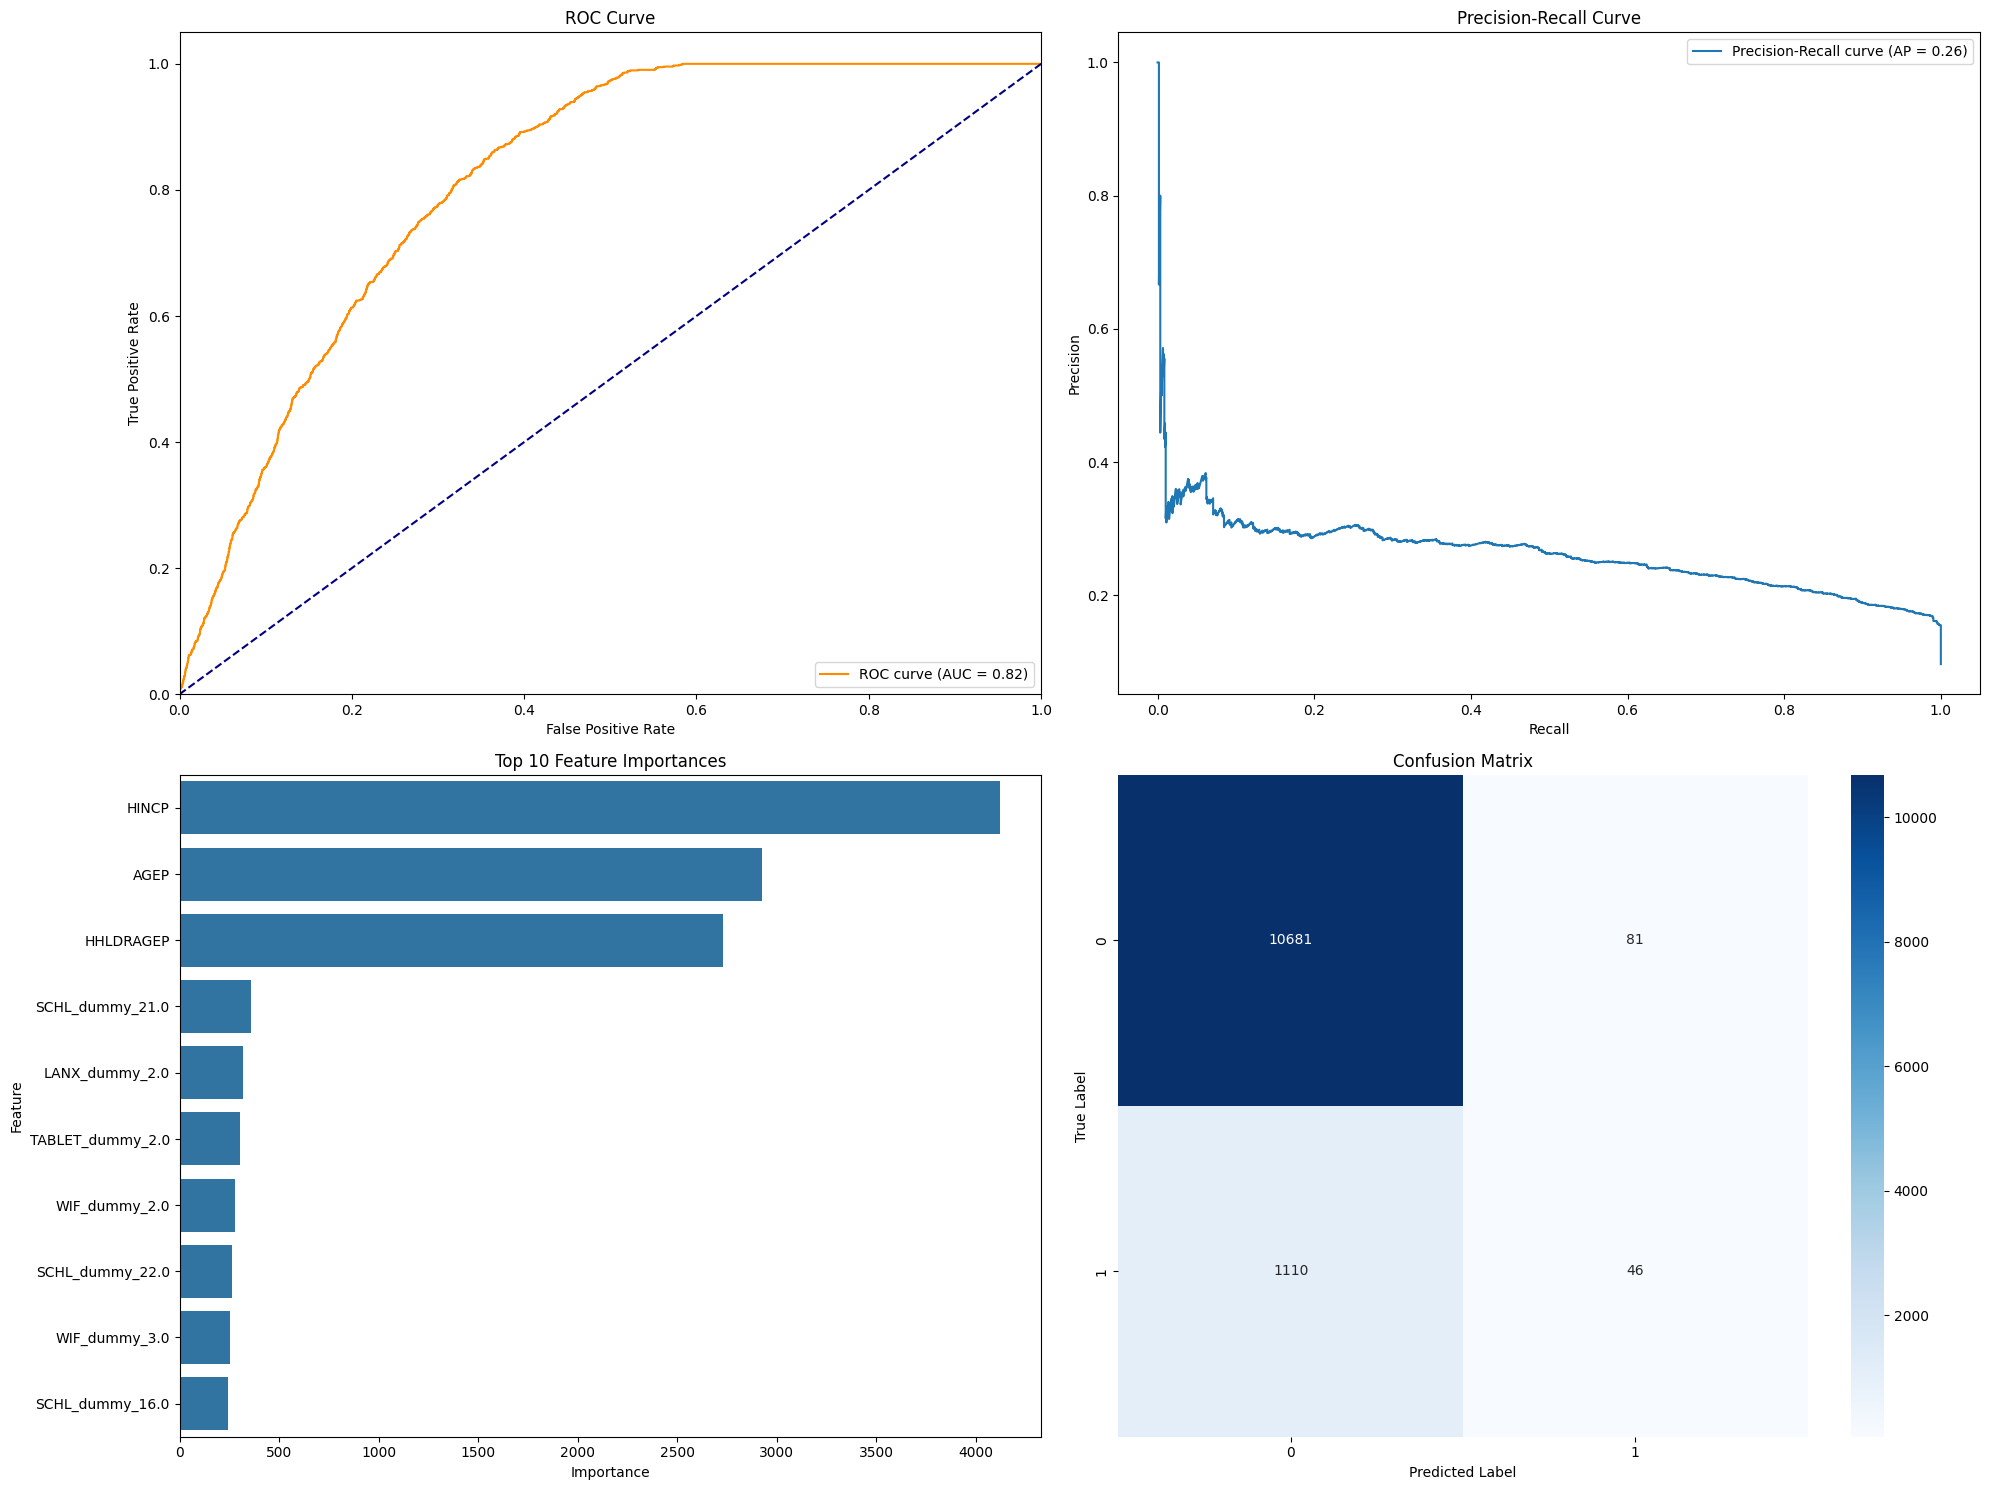


Generating SHAP values...


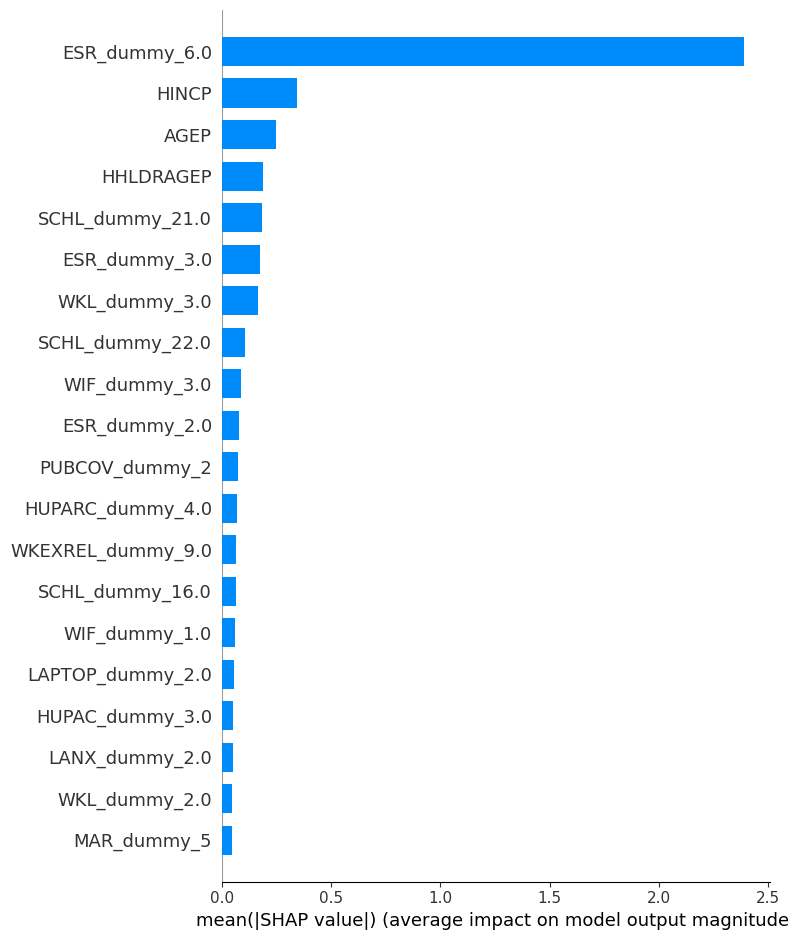

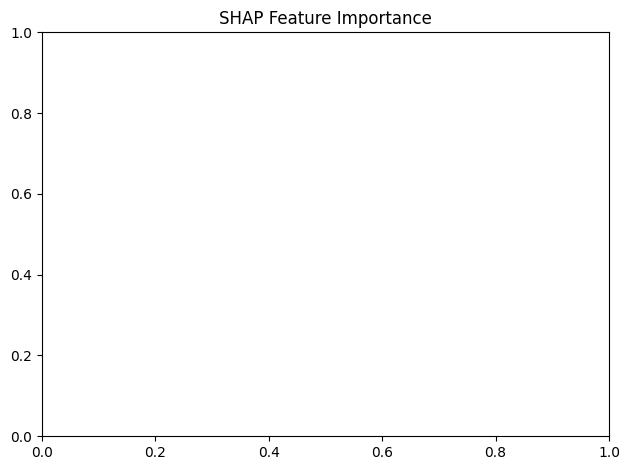

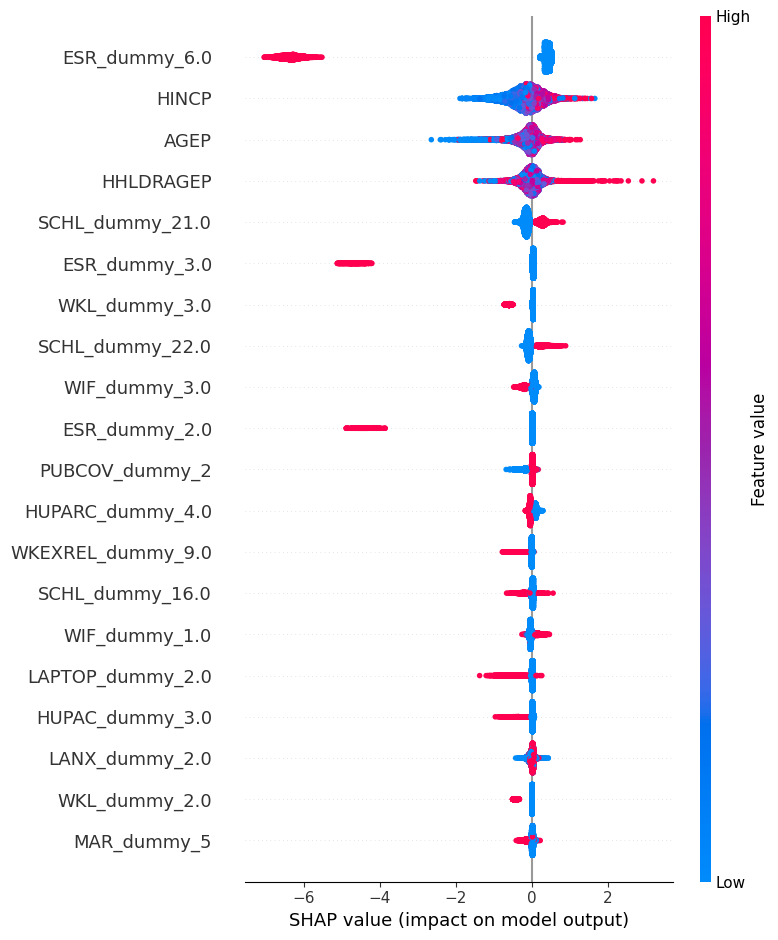

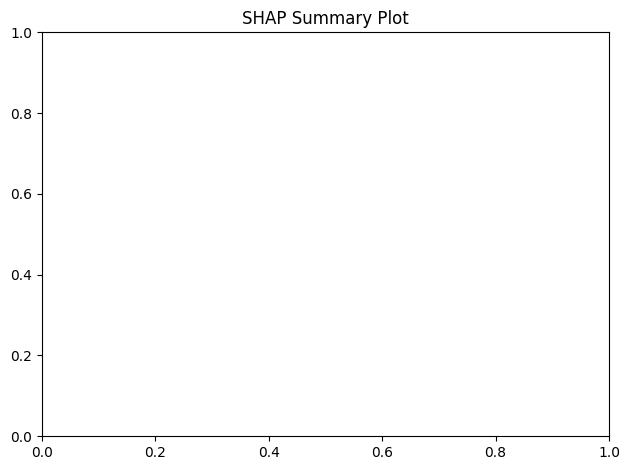

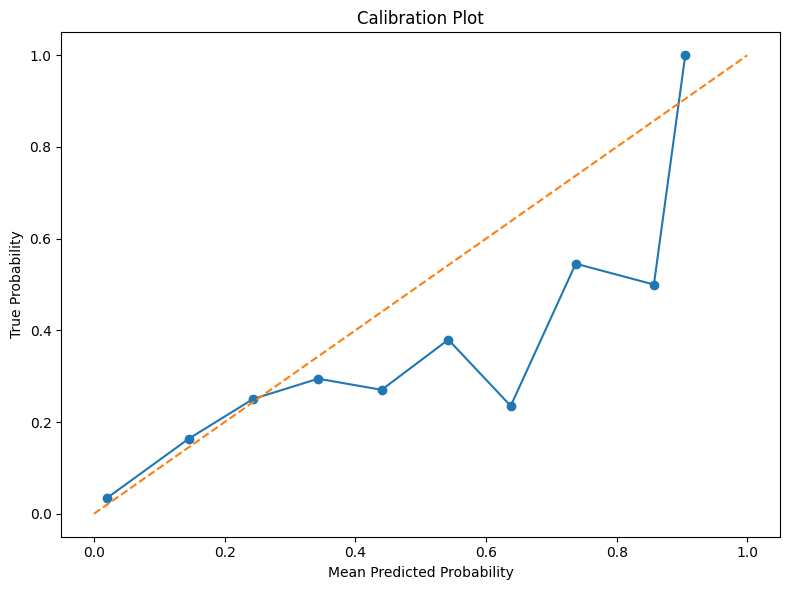

In [ ]:
#| label: results
# Additional Metrics
print("\nCalculating additional performance metrics...")

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate detailed classification metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
total = tn + fp + fn + tp

precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)
prevalence = (tp + fn) / total
negative_predictive_value = tn / (tn + fn)
positive_likelihood_ratio = recall / false_positive_rate
negative_likelihood_ratio = false_negative_rate / specificity

# Print comprehensive metrics
print("\nComprehensive Model Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall/Sensitivity: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Prevalence: {prevalence:.4f}")
print(f"Negative Predictive Value: {negative_predictive_value:.4f}")
print(f"Positive Likelihood Ratio: {positive_likelihood_ratio:.4f}")
print(f"Negative Likelihood Ratio: {negative_likelihood_ratio:.4f}")

# Create visualizations
plt.figure(figsize=(20, 15))

# Plot 1: ROC Curve
plt.subplot(2, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot 2: Precision-Recall Curve
plt.subplot(2, 2, 2)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
plt.plot(recall_curve, precision_curve,
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Plot 3: Feature Importance
plt.subplot(2, 2, 3)
importance = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame(list(importance.items()),
                           columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')

# Plot 4: Confusion Matrix Heatmap
plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# SHAP Analysis
print("\nGenerating SHAP values...")
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

# Calibration plot
plt.figure(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.tight_layout()
plt.show()